## CS441: Applied ML - HW 1

### Part I: MNIST Classification

Include all the code for Part 1 in this section

In [136]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from scipy.ndimage.interpolation import shift

from collections import Counter
import time
import warnings

warnings.filterwarnings('ignore')

# loads MNIST data and reformat to 768-d vectors with values in range 0 to 1
# splits into train/val/test sets and provides indices for subsets of train
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = np.reshape(x_train, (len(x_train), 28*28))
    x_test = np.reshape(x_test, (len(x_test), 28*28))
    maxval = x_train.max()
    x_train = x_train/maxval
    x_test = x_test/maxval
    x_val = x_train[:10000]
    y_val = y_train[:10000]
    x_train = x_train[10000:]
    y_train = y_train[10000:]
    train_indices = dict()
    train_indices['xs'] = np.arange(50)
    train_indices['s'] = np.arange(500)
    train_indices['m'] = np.arange(5000)
    train_indices['all'] = np.arange(50000)
    return (x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices

# displays a set of mnist images
def display_mnist(x, subplot_rows=1, subplot_cols=1):
    if subplot_rows>1 or subplot_cols>1:
        fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
        for i in np.arange(len(x)):
            ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
            ax[i].axis('off')
    else:
        plt.imshow(np.reshape(x, (28,28)), cmap='gray')
        plt.axis('off')
    plt.show()

# counts the number of examples per class
def class_count_mnist(y):
    count = np.zeros((10,),dtype='uint32')
    for i in np.arange(10):
        count[i] = sum(y==i)
    return count

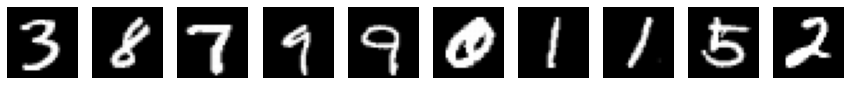

Total size: train=50000, val=10000, test =10000
Train subset size: xs=50, s=500, m=5000, all=50000
Class count for s: [56 57 51 49 46 46 50 51 40 54]


In [137]:
# example of using MNIST load, display, indices, and count functions
(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()
display_mnist(x_train[:10],1,10)
print('Total size: train={}, val={}, test ={}'.format(len(x_train), len(x_val), len(x_test)))
print('Train subset size: xs={}, s={}, m={}, all={}'.format(len(train_indices['xs']),len(train_indices['s']),len(train_indices['m']),len(train_indices['all'])))
print('Class count for s: {}'.format(class_count_mnist(y_train[train_indices['s']])))

In [89]:
# This is a suggested function definition for KNN, but feel free to change it
def classify_KNN(X_trn, y_trn, X_tst, K=1):
    '''
    Classify each data point in X_tst using a K-nearest neighbor classifier based on (X_trn, y_trn), with L2 distance.
    Input: X_trn[i] is the ith training data. y_trn[i] is the ith training label.
           X_tst[i] is the ith example to classify.  K is the number of closest neighbors to use.
    Output: return y_pred, where y_pred[i] is the predicted ith test label
    '''

    # needs code here
    y_pred = np.zeros((len(X_tst), 1))

    for i in range(len(X_tst)):
        dist = np.sqrt(np.sum((X_tst[i] - X_trn) ** 2, axis=1)) # (N, 1)
        topK_label = y_trn[np.argsort(dist)[:K]]

        # count for the most common y
        if K != 1:
            c = Counter(topK_label)
            # print(c)
            label = c.most_common(1)[0][0]
            y_pred[i] = label
        else:
            y_pred[i] = topK_label[0]

    return np.squeeze(y_pred)

In [43]:
# experiment KNN a
x_trn = x_train[train_indices['all']]
y_trn = y_train[train_indices['all']]

start = time.time()
y_pred = classify_KNN(x_trn, y_trn, x_val)
print("Shape of y_pred: ", y_pred.shape)
print(y_val.shape)
end = time.time()

print("Training time for KNN is 0 s. ")
print(f"Average inference time for one example: {(end - start) / x_val.shape[0] * 1000} ms. ")

# report validation error
print(f"validation error: {np.sum(y_pred != y_val) / y_pred.shape[0]}")

# report confusion matrix
print("Confusion matrix for KNN (K=1): \n")
print(confusion_matrix(y_val, y_pred))


Shape of y_pred:  (10000,)
(10000,)
Training time for KNN is 0 s. 
Average inference time for one example: 218.44338574409485 ms. 
validation error: 0.0304
Confusion matrix for KNN (K=1): 

[[ 994    1    0    0    0    0    3    1    1    1]
 [   0 1123    0    0    0    0    0    2    1    1]
 [   6   12  944    8    0    1    1   13    2    4]
 [   2    1    2  982    0   18    2   10    8    7]
 [   0    6    1    0  941    0    2    2    0   28]
 [   2    1    1   14    1  829    9    0    3    3]
 [   4    4    0    0    1    1 1003    0    1    0]
 [   1    5    4    0    0    0    0 1051    0    9]
 [   5   12    4   12    7   10    5    4  879    6]
 [   3    0    0    2    8    2    1   11    1  950]]


In [90]:
class NaiveBayesDiscrete:

    def __init__(self, alpha=1):
        self.alpha = alpha
        self.prior = None
        self.pxy = None

    def train(self, X, y):
        """
        Train P(x_f=v|y=c) for each feature f, value v, and class c.  Can assume 10 classes and that the features are binary variables
        Input: X[i] is the ith training data. y[i] is the ith training label. alpha is the count prior
        Output: return pxy of shape (Nf, 10, 2), where Nf is the number of features; pxy[f,c,v] is P(x_f=v|y=c)
                priori: P_class
        """
        # map feature into 0, 1
        X_norm = np.zeros(X.shape, dtype=int)
        X_norm[np.where(X > 0.5)] = 1

        # form matrix pxy and prior
        N, d = X_norm.shape
        C = len(np.unique(y))
        self.prior = np.zeros(C)
        self.pxy = np.zeros((d, C, 2))  # (784, 10, 2)

        for c in range(10):
            # count for label c
            f_sum = np.sum(X_norm[y == c], axis=0)  # (d, )
            c_sum = np.sum(y == c)
            # update pxy and prior
            self.pxy[:, c, 1] = (f_sum + self.alpha) / (c_sum + 2 * self.alpha)
            self.pxy[:, c, 0] = 1 - self.pxy[:, c, 1]
            self.prior[c] = c_sum / N

    def predict(self, X):
        """
        Evaluate naive bayes for mnist
        Input: pxy is the trained model; X is the test data
        Output: return y_pred, where y_pred[i] is the predicted ith test label
        """
        y_pred = np.zeros(X.shape[0], dtype=int)
        # normalize feature
        X_norm = np.zeros(X.shape, dtype=int)
        X_norm[np.where(X > 0.5)] = 1

        for i in range(len(X_norm)):
            pfc = np.abs(X_norm[i] + self.pxy[:, :, 1].transpose() - 1) # (10, 784)
            log_pfc = np.log(pfc + 1e-5)
            log_pc = np.log(self.prior)
            P_c = log_pc + np.sum(log_pfc, axis=1)

            y_pred[i] = np.argmax(P_c)

        return y_pred

In [91]:
# experiment NB
x_trn = x_train[train_indices['all']]
y_trn = y_train[train_indices['all']]
NB = NaiveBayesDiscrete(alpha=1)

# train
start = time.time()
NB.train(x_trn, y_trn)
end = time.time()
print(f"Training time for NB is {end - start} s. ")


# evaluate
start = time.time()
y_pred = NB.predict(x_val)
end = time.time()
print(f"Average inference time for one example: {(end - start) / x_val.shape[0] * 1000} ms. ")

# report validation error
print(f"Validation error: {np.sum(y_pred != y_val) / y_pred.shape[0]}")

Training time for NB is 0.29471635818481445 s. 
Average inference time for one example: 0.121700119972229 ms. 
Validation error: 0.1634


In [92]:
# don't forget logistic regression!
x_trn = x_train[train_indices['all']]
y_trn = y_train[train_indices['all']]

# train
start = time.time()
cls = LogisticRegression().fit(x_trn, y_trn)
end = time.time()
print(f"Training time for LR is {end - start} s. ")

# evaluate
start = time.time()
y_pred = cls.predict(x_val)
end = time.time()
print(f"Average inference time for one example: {(end - start) / x_val.shape[0] * 1000} ms. ")

# report validation error
print(f"Validation error: {np.sum(y_pred != y_val) / y_pred.shape[0]}")

Training time for LR is 7.791572570800781 s. 
Average inference time for one example: 0.0015618324279785157 ms. 
Validation error: 0.0753


In [44]:
# experiments code
train_size = {'xs': 50, 's': 500, 'm': 5000} # 'all': 50000
all_error = np.array([0.0304, 0.1634, 0.0753])  # error for all train set from (a)
val_error = np.zeros((3, 4))
val_error[:, -1] = all_error

for i, size in enumerate(train_size.keys()):
    x_trn = x_train[train_indices[size]]
    y_trn = y_train[train_indices[size]]

    # KNN
    y_pred = classify_KNN(x_trn, y_trn, x_val)
    val_error[0, i] = np.sum(y_pred != y_val) / y_pred.shape[0]
    # NB
    NB = NaiveBayesDiscrete(alpha=1)
    NB.train(x_trn, y_trn)
    y_pred = NB.predict(x_val)
    val_error[1, i] = np.sum(y_pred != y_val) / y_pred.shape[0]
    # LR
    cls = LogisticRegression().fit(x_trn, y_trn)
    y_pred = cls.predict(x_val)
    val_error[2, i] = np.sum(y_pred != y_val) / y_pred.shape[0]

print(val_error)

[[0.3372 0.1611 0.0682 0.0304]
 [0.4749 0.2393 0.1695 0.1634]
 [0.3503 0.1534 0.1085 0.0753]]


Validation Error:
KNN:  {'50': 0.3372, '500': 0.1611, '5000': 0.0682, '50000': 0.0304}
NB:  {'50': 0.4749, '500': 0.2393, '5000': 0.1695, '50000': 0.1634}
LR:  {'50': 0.3503, '500': 0.1534, '5000': 0.1085, '50000': 0.0753}


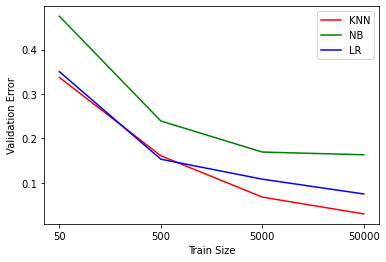

In [45]:
# plot validation error V.S. training size
plt.figure()
x = ['50', '500', "5000", "50000"]
plt.xlabel("Train Size")
plt.ylabel("Validation Error")
plt.plot(x, val_error[0, :], color='r', label='KNN')
plt.plot(x, val_error[1, :], color='g', label='NB')
plt.plot(x, val_error[2, :], color='b', label='LR')
plt.legend()

print(f'Validation Error:')
print("KNN: ", dict(zip(x, val_error[0, :])))
print("NB: ", dict(zip(x, val_error[1, :])))
print("LR: ", dict(zip(x, val_error[2, :])))

In [93]:
x_trn = x_train[train_indices['s']]
y_trn = y_train[train_indices['s']]

In [47]:
# KNN (c)
# K can be any integer, I choose 1...10 which is reasonable
K_list = range(1, 11)
val_error = np.zeros(len(K_list))
for i, K in enumerate(K_list):
    y_pred = classify_KNN(x_trn, y_trn, x_val, K=K)
    val_error[i] = np.sum(y_pred != y_val) / y_pred.shape[0]

print(f"The best K for KNN is {np.argmin(val_error) + 1}")
print(val_error)

The best K for KNN is 1
[0.1611 0.1611 0.1703 0.1692 0.1816 0.1799 0.1921 0.1955 0.2059 0.2083]


In [94]:
y_pred = classify_KNN(x_trn, y_trn, x_test, K=1)
print(f"Test error for K=1: {np.sum(y_pred != y_test) / y_pred.shape[0]}")

Test error for K=1: 0.1622


In [49]:
# NB (c)
alpha_list = np.linspace(0.1, 2, 20)
val_error = np.zeros(len(alpha_list))
for i, alpha in enumerate(alpha_list):
    NB = NaiveBayesDiscrete(alpha=alpha)
    NB.train(x_trn, y_trn)
    y_pred = NB.predict(x_val)
    val_error[i] = np.sum(y_pred != y_val) / y_pred.shape[0]

print(f"The best alpha for NB is {(np.argmin(val_error) + 1) * 0.1}")
print(val_error)

The best alpha for NB is 0.1
[0.2163 0.2199 0.2236 0.2258 0.2284 0.2301 0.2327 0.2348 0.2363 0.2393
 0.2411 0.2426 0.2444 0.2462 0.2483 0.2495 0.2511 0.2518 0.2535 0.2551]


In [95]:
NB = NaiveBayesDiscrete(alpha=0.1)
NB.train(x_trn, y_trn)
y_pred = NB.predict(x_test)
print(f"Test error for alpha=0.1: {np.sum(y_pred != y_test) / y_pred.shape[0]}")

Test error for alpha=0.1: 0.2023


In [50]:
# LR (c)
C_list = np.linspace(0.1, 2, 20)
for i, C in enumerate(C_list):
    cls = LogisticRegression(C=C).fit(x_trn, y_trn)
    y_pred = cls.predict(x_val)
    val_error[i] = np.sum(y_pred != y_val) / y_pred.shape[0]

print(f"The best C for LR is {(np.argmin(val_error) + 1) * 0.1:.1f}")
print(val_error)

The best C for LR is 0.7
[0.1563 0.1541 0.154  0.154  0.1538 0.1534 0.1531 0.1537 0.1536 0.1534
 0.154  0.1533 0.1535 0.1534 0.1533 0.1532 0.1536 0.1533 0.154  0.1538]


In [97]:
cls = LogisticRegression(C=0.7).fit(x_trn, y_trn)
y_pred = cls.predict(x_test)
print(f"Test error for C=0.7: {np.sum(y_pred != y_test) / y_pred.shape[0]}")

Test error for C=0.7: 0.1481


## Part 2: Temperature Regression

Include all your code for part 2 in this section.  You can copy-paste code from part 1 if it is re-usable.

In [142]:
import numpy as np
# from google.colab import drive
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# load data (modify to match your data directory or comment)
def load_temp_data():
    # drive.mount('/content/drive')
    # datadir = "/content/drive/My Drive/CS441/hw1/"
    T = np.load('temperature_data.npz')
    x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
    return (x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)

# plot one data point for listed cities and target temperature
def plot_temps(x, y, cities, feature_to_city, feature_to_day, target_date):
    nc = len(cities)
    ndays = 5
    xplot = np.array([-5,-4,-3,-2,-1])
    yplot = np.zeros((nc,ndays))
    for f in np.arange(len(x)):
        for c in np.arange(nc):
            if cities[c]==feature_to_city[f]:
                yplot[feature_to_day[f]+ndays,c] = x[f]
    plt.plot(xplot,yplot)
    plt.legend(cities)
    plt.plot(0, y, 'b*', markersize=10)
    plt.title('Predict Temp for Cleveland on ' + target_date)
    plt.xlabel('Day')
    plt.ylabel('Avg Temp (C)')
    plt.show()

Feature 361: city = Cleveland, day= -1
Baseline - predict same as previous day: RMSE=3.460601246750482, MAE=1.9500000000000006


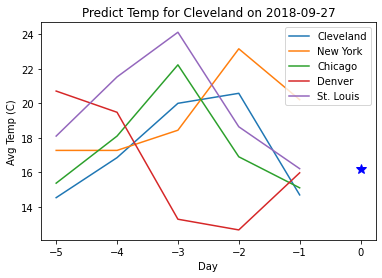

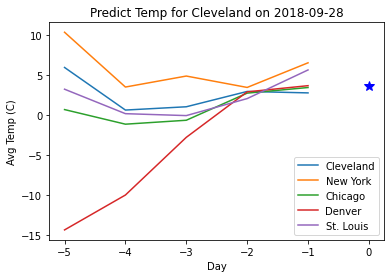

In [143]:
# load data (may need to modify file location in preceding cell)
(x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()

# example of displaying information related to a feature index
f = 361
print('Feature {}: city = {}, day= {}'.format(f,feature_to_city[f], feature_to_day[f]))

# example of computing RMSE and median absolute error (for baseline of predicting based on previous day's temperature in Cleveland)
baseline_rmse = np.sqrt(np.mean((y_val[1:]-y_val[:-1])**2)) # root mean squared error
baseline_mae = np.median(np.abs(y_val[1:]-y_val[:-1])) # median absolute error
print('Baseline - predict same as previous day: RMSE={}, MAE={}'.format(baseline_rmse, baseline_mae))

# plots temperatures for preceding days for given cities, and target (Cleveland) temp
plot_temps(x_val[0], y_val[0], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[0])
plot_temps(x_val[100], y_val[100], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[1])

In [111]:
# print(x_train.shape)
# print(y_train.shape)
# print(y_val[:10])
# print(x_val.shape)
# print(y_val.shape)
# print(dates_train[:10])
# print(dates_val[:10])
# print(feature_to_city[:83])
# print(feature_to_city[83:166])
# print(feature_to_day[:83])

In [112]:
# This is a suggested function definition for KNN, but feel free to change it
def classify_KNN_avg(X_trn, y_trn, X_tst, K=3):
    '''
    Classify each data point in X_tst using a K-nearest neighbor classifier based on (X_trn, y_trn), with L2 distance.
    Input: X_trn[i] is the ith training data. y_trn[i] is the ith training label. K is the number of closest neighbors to use.
    Output: return y_pred, where y_pred[i] is the predicted ith test label
    '''
    # needs code
    y_pred = np.zeros((len(X_tst), 1))

    for i in range(len(X_tst)):
        dist = np.sqrt(np.sum((X_tst[i] - X_trn) ** 2, axis=1)) # (N, 1)
        topK_label = y_trn[np.argsort(dist)[:K]]

        # count for the most common y
        if K != 1:
            label = np.sum(topK_label) / K
            y_pred[i] = label
        else:
            y_pred[i] = topK_label[0]

    return np.squeeze(y_pred)

In [101]:
# experiment KNN
y_pred = classify_KNN_avg(x_train, y_train, x_val, K=3)

# RMS Error & MA Error
print(f"RMSE: {np.sqrt(np.mean((y_pred-y_val)**2))}")
print(f"MAE: {np.median(np.abs(y_pred-y_val))}")

RMSE: 3.2266843182278797
MAE: 2.083333333333333


In [113]:
class NaiveBayesGaussian:

    def __init__(self, std_prior=0):
        self.mu = None
        self.std = None
        self.std_prior = 0

    def train(self, X, y):
        """
        Train NB, assuming that X[f]-y is a Gaussian
        Input: X[i] is the ith training data. y[i] is the ith training label. std_prior is a value to add to std
        """
        self.mu = np.mean(np.expand_dims(y, axis=1) - X, axis=0)
        self.std = np.std(np.expand_dims(y, axis=1) - X, axis=0) + self.std_prior

    def predict(self, X):
        """
        Evaluate naive bayes for temp
        Input: X is the test data
        Output: return y_pred, where y_pred[i] is the predicted ith test value
        """
        y_pred = np.zeros(X.shape[0])
        w = 1 / self.std ** 2
        for i in range(len(X)):
            y_pred[i] = np.sum((X[i] + self.mu) * w) / np.sum(w)

        return y_pred

In [103]:
# experiment GaussianNB
NBG = NaiveBayesGaussian()
NBG.train(x_train, y_train)
y_pred = NBG.predict(x_val)

# RMS Error & MA Error
print(f"RMSE: {np.sqrt(np.mean((y_pred-y_val)**2))}")
print(f"MAE: {np.median(np.abs(y_pred-y_val))}")

RMSE: 3.784987716337962
MAE: 2.463307258022755


In [3]:
# Don't forget linear regression!
clf = Ridge().fit(x_train, y_train)
y_pred = clf.predict(x_val)

# RMS Error & MA Error
print(f"RMSE: {np.sqrt(np.mean((y_pred-y_val)**2))}")
print(f"MAE: {np.median(np.abs(y_pred-y_val))}")

RMSE: 2.4382370170678724
MAE: 1.631913107117736


In [5]:
# Feature analysis
clf = Lasso().fit(x_train, y_train)
print(f"Feature coefficients having magnitude greater than 0.001: {np.sum(clf.coef_ > 0.001)} \n")
feature_idx = np.argsort(np.abs(clf.coef_))[-10:][::-1]

for idx in feature_idx:
    print(f"Feature number: {idx} | City: {feature_to_city[idx]} | Day: {feature_to_day[idx]}")

Feature coefficients having magnitude greater than 0.001: 11 

Feature number: 334 | City: Chicago | Day: -1
Feature number: 347 | City: Minneapolis | Day: -1
Feature number: 405 | City: Grand Rapids | Day: -1
Feature number: 366 | City: Kansas City | Day: -1
Feature number: 361 | City: Cleveland | Day: -1
Feature number: 307 | City: Omaha | Day: -2
Feature number: 367 | City: Indianapolis | Day: -1
Feature number: 264 | City: Minneapolis | Day: -2
Feature number: 9 | City: Boston | Day: -5
Feature number: 236 | City: Springfield | Day: -3


In [118]:
# experiment new feature
x_train_10 = x_train[:, feature_idx]
x_val_10 = x_val[:, feature_idx]

# KNN
print("KNN: ")
y_pred = classify_KNN_avg(x_train_10, y_train, x_val_10, K=3)

print(f"RMSE: {np.sqrt(np.mean((y_pred-y_val)**2))}")
print(f"MAE: {np.median(np.abs(y_pred-y_val))}")

# GaussianNB
print("\nGaussian NB: ")
NBG = NaiveBayesGaussian()
NBG.train(x_train_10, y_train)
y_pred = NBG.predict(x_val_10)

print(f"RMSE: {np.sqrt(np.mean((y_pred-y_val)**2))}")
print(f"MAE: {np.median(np.abs(y_pred-y_val))}")

# LR
print("\nLinear Regression")
clf = Ridge().fit(x_train_10, y_train)
y_pred = clf.predict(x_val_10)

print(f"RMSE: {np.sqrt(np.mean((y_pred-y_val)**2))}")
print(f"MAE: {np.median(np.abs(y_pred-y_val))}")

KNN: 
RMSE: 2.8231963490998595
MAE: 1.5666666666666664

Gaussian NB: 
RMSE: 2.789998187480326
MAE: 1.5111610645297242

Linear Regression
RMSE: 2.261976344855621
MAE: 1.2403423472847344


## Part 3: Stretch Goals
Include all your code used for part 3 in this section. You can copy-paste code from parts 1 or 2 if it is re-usable.

### a) Improve MNIST classification

In [138]:
from scipy.ndimage.interpolation import shift

In [139]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.reshape(x_train, (len(x_train), 28*28))
x_test = np.reshape(x_test, (len(x_test), 28*28))
maxval = x_train.max()
x_train = x_train/maxval
x_test = x_test/maxval
x_val = x_train[:10000]
y_val = y_train[:10000]
x_train = x_train[10000:]
y_train = y_train[10000:]
x_train.shape

(50000, 784)

In [140]:
clf = LogisticRegression().fit(x_train, y_train)
y_pred_val = clf.predict(x_val)
print(f"Validation error: {np.sum(y_pred_val != y_val) / y_pred_val.shape[0]}")
y_pred_test = clf.predict(x_test)
print(f"Validation error: {np.sum(y_pred_test != y_test) / y_pred_test.shape[0]}")

Validation error: 0.0753
Validation error: 0.0737


In [141]:
# data argumentation

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

X_train_augmented = [image for image in x_train]
y_train_augmented = [image for image in y_train]

for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):
     for image, label in zip(x_train, y_train):
             X_train_augmented.append(shift_image(image, dx, dy))
             y_train_augmented.append(label)


# Shuffle the dataset
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = np.array(X_train_augmented)[shuffle_idx]
y_train_augmented = np.array(y_train_augmented)[shuffle_idx]

In [ ]:
clf = LogisticRegression(C=0.4, multi_class='multinomial', penalty='l2', solver='sag')
clf.fit(X_train_augmented, y_train_augmented)
y_pred = clf.predict(x_val)
print(f"Validation error: {np.sum(y_pred != y_val) / y_pred.shape[0]}")

In [ ]:
### b) Improve Temperature regression performance

In [146]:
# Don't forget linear regression!
clf = Ridge().fit(x_train, y_train)
y_pred = clf.predict(x_val)

# RMS Error & MA Error
print("Val: ")
print(f"RMSE: {np.sqrt(np.mean((y_pred-y_val)**2))}")
# print(f"MAE: {np.median(np.abs(y_pred-y_val))}")

y_pred = clf.predict(x_test)
print("Test: ")
print(f"RMSE: {np.sqrt(np.mean((y_pred-y_test)**2))}")

Val: 
RMSE: 2.4382370170678724
Test: 
RMSE: 2.1608605260813167


In [157]:
# Feature analysis
clf = Lasso(alpha=0.75).fit(x_train, y_train)
print(f"Feature coefficients having magnitude greater than 0.001: {np.sum(clf.coef_ > 0.001)} \n")
feature_idx = np.argsort(np.abs(clf.coef_))[-16:][::-1]

Feature coefficients having magnitude greater than 0.001: 13 



In [158]:
# experiment new feature
x_train_filter = x_train[:, feature_idx]
x_val_filter = x_val[:, feature_idx]
x_test_filter = x_test[:, feature_idx]

In [162]:
clf = Ridge(alpha=0.6, solver='svd').fit(x_train_filter, y_train)
y_pred = clf.predict(x_val_filter)
print("Val: ")
print(f"RMSE: {np.sqrt(np.mean((y_pred-y_val)**2))}")
# print(f"MAE: {np.median(np.abs(y_pred-y_val))}")
y_pred = clf.predict(x_test_filter)
print("Test: ")
print(f"RMSE: {np.sqrt(np.mean((y_pred-y_test)**2))}")
# print(f"MAE: {np.median(np.abs(y_pred-y_test))}")

Val: 
RMSE: 2.2531446688322156
Test: 
RMSE: 2.049356352970692
